In [13]:
import os
import shutil
import numpy as np
import base64
import imageio
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import IPython

import tensorflow as tf

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.drivers import dynamic_step_driver, dynamic_episode_driver
from tf_agents.environments import suite_pybullet, tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network, normal_projection_network
from tf_agents.policies import greedy_policy, random_tf_policy, policy_saver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

TimeStep spec:
 TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), observation=BoundedArraySpec(shape=(26,), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)) 

Observation spec:
 BoundedArraySpec(shape=(26,), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38) 

Action spec:
 BoundedArraySpec(shape=(6,), dtype=dtype('float32'), name='action', minimum=-1.0, maximum=1.0) 



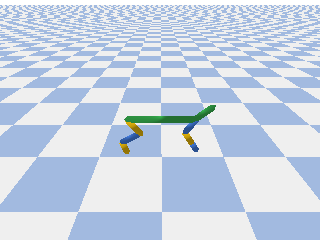

In [14]:
env_name = "HalfCheetahBulletEnv-v0"
train_env = suite_pybullet.load(env_name)

print("TimeStep spec:\n", train_env.time_step_spec(), "\n")
print("Observation spec:\n", train_env.observation_spec(), "\n")
print("Action spec:\n", train_env.action_spec(), "\n")

train_env.reset()
Image.fromarray(train_env.render())

In [23]:
tf.get_logger().setLevel('WARNING')
debug = False

# Hyper Parameters
if debug:
    initial_collect_steps = 10
    collect_steps_per_iteration = 1
    replay_buffer_max_len = 1000000
    batch_size = 256
    critic_learning_rate = 3e-4
    actor_learning_rate = 3e-4
    alpha_learning_rate = 3e-4
    target_update_tau = 0.005
    target_update_period = 1
    gamma = 0.99
    reward_scale_factor = 1.0
    gradient_clipping = None
    actor_fc_layer_params = (256, 256)
    critic_joint_fc_layer_params = (256, 256)
    log_interval = 5000
    num_eval_episodes = 1
    eval_interval = 10
else:
    initial_collect_steps = 10000
    collect_steps_per_iteration = 1
    replay_buffer_max_len = 1000000
    batch_size = 256
    critic_learning_rate = 3e-4
    actor_learning_rate = 3e-4
    alpha_learning_rate = 3e-4
    target_update_tau = 0.005
    target_update_period = 1
    gamma = 0.99
    reward_scale_factor = 1.0
    gradient_clipping = None
    actor_fc_layer_params = (256, 256)
    critic_joint_fc_layer_params = (256, 256)
    log_interval = 5000
    num_eval_episodes = 3
    eval_interval = 5000




def create_save_dir(save_dir, create_directory=True, replace_if_test=True):
    """If create_directory is True, check existance and create `save_dir/logs` and `save_dir/ckpt`.
    Otherwise, only make director names and return.
    """
    if create_directory and replace_if_test:
        # Check if saving directory is valid
        if "test" in save_dir and os.path.exists(save_dir):
            shutil.rmtree(save_dir)
        if os.path.exists(save_dir):
            raise ValueError("Directory {} already exists.".format(save_dir))

    # Create save dir
    ckpt_dir = os.path.join(save_dir, 'checkpoints')
    model_dir = os.path.join(save_dir, 'models')
    log_dir = os.path.join(save_dir, 'logs')
    
    if create_directory:
        os.makedirs(save_dir)
        os.makedirs(ckpt_dir)
        os.makedirs(model_dir)
        os.makedirs(log_dir)
        
    return ckpt_dir, model_dir, log_dir



def setup_agent(tf_train_env):
    critic_net = critic_network.CriticNetwork(
        input_tensor_spec=(tf_train_env.observation_spec(), tf_train_env.action_spec()),
        joint_fc_layer_params=critic_joint_fc_layer_params,
        activation_fn=tf.nn.relu,
    )
    
    def normal_projection_net(action_spec, init_means_output_factor=.1):
        return normal_projection_network.NormalProjectionNetwork(
            sample_spec=action_spec,
            init_means_output_factor=init_means_output_factor,
            mean_transform=None,
            state_dependent_std=True,
            std_transform=sac_agent.std_clip_transform,
            scale_distribution=True,
        )

    actor_net = actor_distribution_network.ActorDistributionNetwork(
        input_tensor_spec=tf_train_env.observation_spec(),
        output_tensor_spec=tf_train_env.action_spec(),
        fc_layer_params=actor_fc_layer_params,
        activation_fn=tf.nn.relu,
        continuous_projection_net=normal_projection_net,
    )

    
    # Setup agent
    global_step = tf.Variable(0, dtype=np.int32, name="global_step")
    agent = sac_agent.SacAgent(
        time_step_spec=tf_train_env.time_step_spec(),
        action_spec=tf_train_env.action_spec(),
        critic_network=critic_net,
        actor_network=actor_net,
        actor_optimizer=tf.optimizers.Adam(learning_rate=actor_learning_rate),
        critic_optimizer=tf.optimizers.Adam(learning_rate=critic_learning_rate),
        alpha_optimizer=tf.optimizers.Adam(learning_rate=alpha_learning_rate),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        td_errors_loss_fn=common.element_wise_squared_loss,
        gamma=gamma,
        reward_scale_factor=reward_scale_factor,
        gradient_clipping=gradient_clipping,
        train_step_counter=global_step,
    )
    agent.train = common.function(agent.train)  # optimize execution
    
    print("Critic Network:\n")
    critic_net.summary()
    print("\n\nActor Network:\n")
    actor_net.summary()
    
    return agent



def train(save_dir, train_iterations=100000, checkpoint_dir=None):
    """
    Params
    ---
    checkpoint_dir: If specified, load data from the latest checkpoint and resume training.
    """
    ckpt_dir, model_dir, log_dir = create_save_dir(save_dir, create_directory=(checkpoint_dir is None))
    if checkpoint_dir is not None:
        assert os.path.normpath(ckpt_dir) == os.path.normpath(checkpoint_dir),\
            "ckpt_dir {} != checkpoint_dir {}".format(ckpt_dir, checkpoint_dir)
    
    summary_writer = tf.summary.create_file_writer(log_dir)
    
    
    env_name = "HalfCheetahBulletEnv-v0"
    train_env, eval_env = suite_pybullet.load(env_name), suite_pybullet.load(env_name)
    tf_train_env, tf_eval_env = tf_py_environment.TFPyEnvironment(train_env), tf_py_environment.TFPyEnvironment(eval_env)


    # Setup networks
    agent = setup_agent(tf_train_env)


    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=agent.collect_data_spec,
        batch_size=tf_train_env.batch_size,
        max_length=replay_buffer_max_len)

    
    
    metrics = {
        'epoch': tf.Variable([], shape=(None,), name='epoch'),
        'loss': tf.Variable([], shape=(None,), name='loss'),
        'eval_epoch': tf.Variable([], shape=(None,), name='eval_epoch'),
        'eval_return': tf.Variable([], shape=(None,), name='eval_return'),
    }

    
    # Setup a Checkpointer
    checkpointer = common.Checkpointer(
        ckpt_dir=ckpt_dir, max_to_keep=3,
        agent=agent, policy=agent.policy, replay_buffer=replay_buffer,
        global_step=agent.train_step_counter, **metrics)
    checkpointer.initialize_or_restore()
    
    # Setup policy saver
    p_saver = policy_saver.PolicySaver(agent.policy)
    

    # Setupt training
    def evaluate_policy(env, policy, num_episode=5):
        avg_return = tf_metrics.AverageReturnMetric()
        eval_driver = dynamic_episode_driver.DynamicEpisodeDriver(
            env, policy, observers=[avg_return], num_episodes=num_episode)
        eval_driver.run()
        return avg_return.result().numpy()


    initial_step = agent.train_step_counter.value().numpy()
    if initial_step == 0:
        print("\n\nEvaluate agent policy before training")
        avg_return = evaluate_policy(tf_eval_env, agent.policy, num_eval_episodes)
        print("Avg.return (before training): {:.1f}".format(avg_return))

        # Collect initial samples
        initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
            tf_train_env, agent.collect_policy, observers=[replay_buffer.add_batch], num_steps=initial_collect_steps)
        initial_collect_driver.run()
    else:
        print('Global step {}. Skip initial evaluation and data collection.'.format(initial_step))
    
    
    steps_in_train_env = tf_metrics.EnvironmentSteps()
    collect_driver = dynamic_step_driver.DynamicStepDriver(
        tf_train_env, agent.collect_policy,
        observers=[steps_in_train_env, replay_buffer.add_batch],
        num_steps=collect_steps_per_iteration)

    
    dataset = replay_buffer.as_dataset(sample_batch_size=batch_size, num_steps=2, num_parallel_calls=3).prefetch(3)
    dataset_iterator = iter(dataset)

        
    # Start trining loop
    for _ in tqdm(range(initial_step, train_iterations), initial=initial_step, total=train_iterations):
        global_step = agent.train_step_counter.value().numpy()
        
        collect_driver.run()
        experiences, _ = next(dataset_iterator)
        loss = agent.train(experiences)
        
        metrics['epoch'].assign(np.append(metrics['epoch'].value(), global_step))
        metrics['loss'].assign(np.append(metrics['loss'].value(), loss.loss))

        
        with summary_writer.as_default():
            tf.summary.scalar("loss", loss.loss, step=global_step)
            
        checkpointer.save(agent.train_step_counter)
        
        if global_step % eval_interval == 0:
            avg_return = evaluate_policy(tf_eval_env, agent.policy, num_eval_episodes)
            metrics['eval_epoch'].assign(np.append(metrics['eval_epoch'].value(), global_step))
            metrics['eval_return'].assign(np.append(metrics['eval_return'].value(), avg_return))

            with summary_writer.as_default():
                tf.summary.scalar("return", avg_return, step=global_step)
                tf.summary.scalar("return - step", avg_return, step=steps_in_train_env.result().numpy())
    
            # save model
            p_saver.save(os.path.join(model_dir, "latest_model"))
    
    return agent.policy
    
    
    
    
# Evaluate and visualize
def embed_mp4(filename):
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)


def evaluate_policy_and_save_video(py_env, policy, video_filename, num_episodes=5, fps=30):
    tf_env = tf_py_environment.TFPyEnvironment(py_env)
    
    with imageio.get_writer(video_filename, fps=fps) as video:
        # Run policy
        returns = []
        
        for i in range(num_episodes):
            time_step = tf_env.reset()
            video.append_data(py_env.render())
            episode_return = 0.
            
            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = tf_env.step(action_step.action)
                episode_return += time_step.reward
                video.append_data(py_env.render())
                
            returns.append(episode_return)
            print("Eval Episode {} --- Return: {}".format(i, episode_return))
            
        print("Avg. return: {:.1f}(std {:.1f})".format(np.mean(returns), np.std(returns)))
                
    return embed_mp4(video_filename)

In [22]:
save_dir_name = "sac_halfcheetah_1"
save_dir_path = os.path.join("results", save_dir_name)

!rm -r $save_dir_path
trained_policy = train(save_dir_path)
# # trained_policy = train("results/sac_halfcheetah_1", checkpoint_dir="results/sac_halfcheetah_1/checkpoints", train_iterations=168)

eval_env = suite_pybullet.load("HalfCheetahBulletEnv-v0")
evaluate_policy_and_save_video(eval_env, trained_policy, os.path.join(save_dir_path, "evaluation.mp4"), num_episodes=3)

rm: results/sac_halfcheetah_1: No such file or directory
Critic Network:

Model: "CriticNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         multiple                  0         
_________________________________________________________________
flatten_14 (Flatten)         multiple                  0         
_________________________________________________________________
flatten_15 (Flatten)         multiple                  0         
_________________________________________________________________
joint_mlp/dense (Dense)      multiple                  8448      
_________________________________________________________________
joint_mlp/dense (Dense)      multiple                  65792     
_________________________________________________________________
value (Dense)                multiple                  257       
Total params: 74,497
Trainable params: 74,497

  0%|          | 0/100000 [00:00<?, ?it/s]

Avg.return (before training): -1348.0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
  0%|          | 20/100000 [00:38<53:57:51,  1.94s/it]


KeyboardInterrupt: 